In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [47]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [48]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442100110323_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

,READ_DATE,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,KWH_EXP_MA,KWH_EXP_ES,trend_ma,cycle_ma
0,2019-01-01,1.704497,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5,1.870943,1.678119,9.991498,-8.120555
1,2019-01-02,1.804380,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7,1.870943,2.057167,9.991252,-8.120309
2,2019-01-03,1.606232,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1,1.870943,2.029903,9.991007,-8.120064
3,2019-01-04,1.220510,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1,1.870943,1.976301,9.990761,-8.119818
4,2019-01-05,0.980424,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2,1.870943,1.704463,9.990515,-8.119572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2024-05-27,64.703542,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,34.669681,64.771224,8.280109,26.389572
1974,2024-05-28,63.751474,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,36.264897,66.238063,8.279209,27.985689
1975,2024-05-29,68.610622,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,38.022085,62.751439,8.278308,29.743777
1976,2024-05-30,65.846084,29.7,25.0,35.0,106.0,7.8,1009.7,29.6,73.0,0.0,10.6,39.687122,66.925352,8.277408,31.409714


In [49]:
# # Menghitung nilai lambda untuk data harian berdasarkan aturan skala dari Ravn & Uhlig (2002)
# # Rumus umum:
# # lambda_new = lambda_base * (f_new / f_base) ** 4
# # Di mana:
# # - lambda_base = 1600 (untuk data kuartalan)
# # - f_base = 4 (frekuensi data kuartalan: 4 titik per tahun)
# # - f_new = 252 (jika hanya hari kerja) atau 365 (jika termasuk semua hari)

# # Perhitungan lambda untuk data harian (semua hari, 365 hari/tahun)
# lambda_daily_365 = 1600 * (365 / 4) ** 4  # Hasil: sekitar 69.3 x 10^9
# print(lambda_daily_365)
# # decompose menggunakan hpfilter
# cycle, trend = hpfilter(df['KWH_EXP_ES'], lamb=lambda_daily_365)
# df['trend_es'] = trend
# df['cycle_es'] = cycle

# # plot perbedaan data KWH_EXP dengan trend, KWH_EXP dengan cycle
# fig, ax = plt.subplots(2, 1, figsize=(12, 8))
# ax[0].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[0].plot(df['READ_DATE'], df['trend_es'], label='Trend')
# ax[0].legend()

# ax[1].plot(df['READ_DATE'], df['KWH_EXP_ES'], label='KWH_EXP_ES')
# ax[1].plot(df['READ_DATE'], df['cycle_es'], label='Cycle')
# ax[1].legend()

# plt.show()


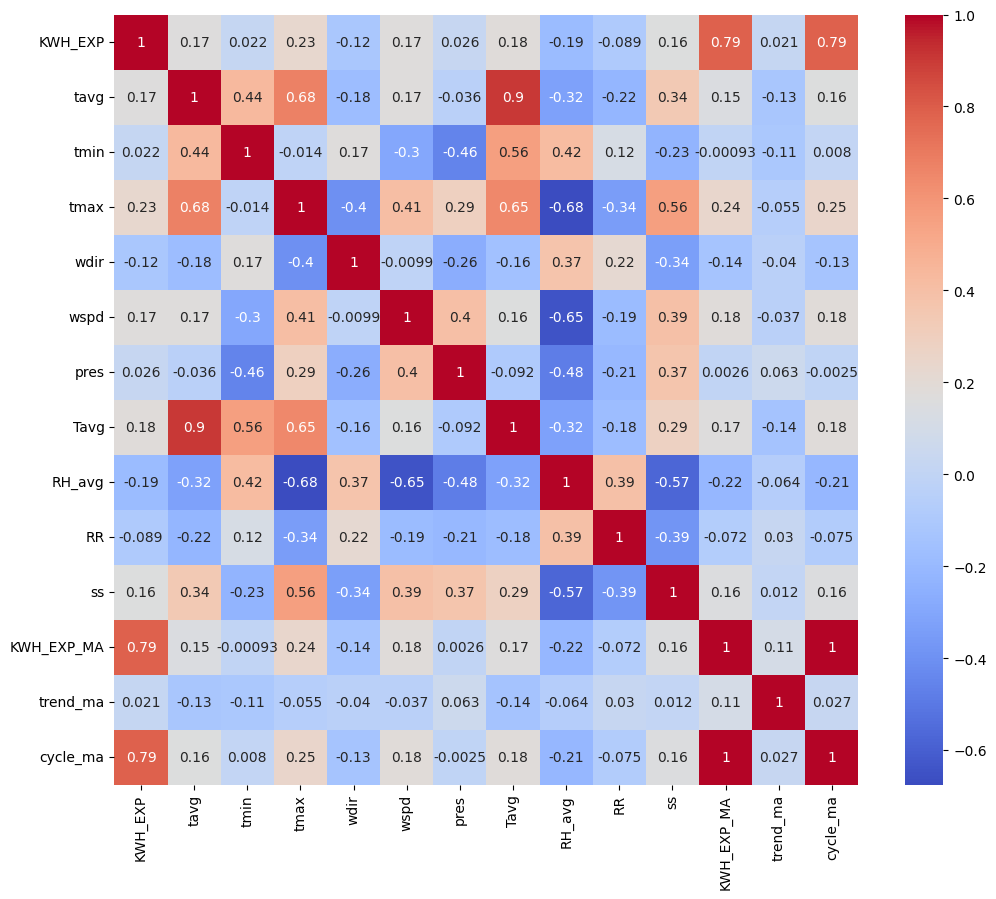

In [50]:
# correlation plot
corr = df.copy()
corr.drop(['READ_DATE', 'KWH_EXP_ES'], axis=1, inplace=True)
corr = corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [51]:
df.columns

Index(['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres',
       'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma',
       'cycle_ma'],
      dtype='object')

In [52]:
df.set_index('READ_DATE', inplace=True)

df.drop(['KWH_EXP', 'KWH_EXP_ES'], axis=1, inplace=True)
df.columns

Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA', 'trend_ma', 'cycle_ma'],
      dtype='object')

In [53]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [54]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_ES']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_ES']])


In [55]:
train_scaled_features

array([[-1.718197  ,  1.02028777, -1.55236723, ..., -1.19537752,
         1.23201777, -1.25298447],
       [-1.43304526,  0.46910278, -2.13049838, ..., -1.19537752,
         1.23129498, -1.25294881],
       [-2.76375338,  0.39036207, -3.22894758, ..., -1.19537752,
         1.23057218, -1.25291316],
       ...,
       [-1.52809584,  0.54784349, -1.55236723, ..., -0.99855221,
        -2.19122297, -0.88781275],
       [-1.52809584,  0.39036207, -3.22894758, ..., -1.01296188,
        -2.19518077, -0.90198899],
       [-0.19738772,  1.02028777, -0.80079673, ..., -1.03280849,
        -2.19913569, -0.92158791]])

In [56]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [57]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP_MA'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 6: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


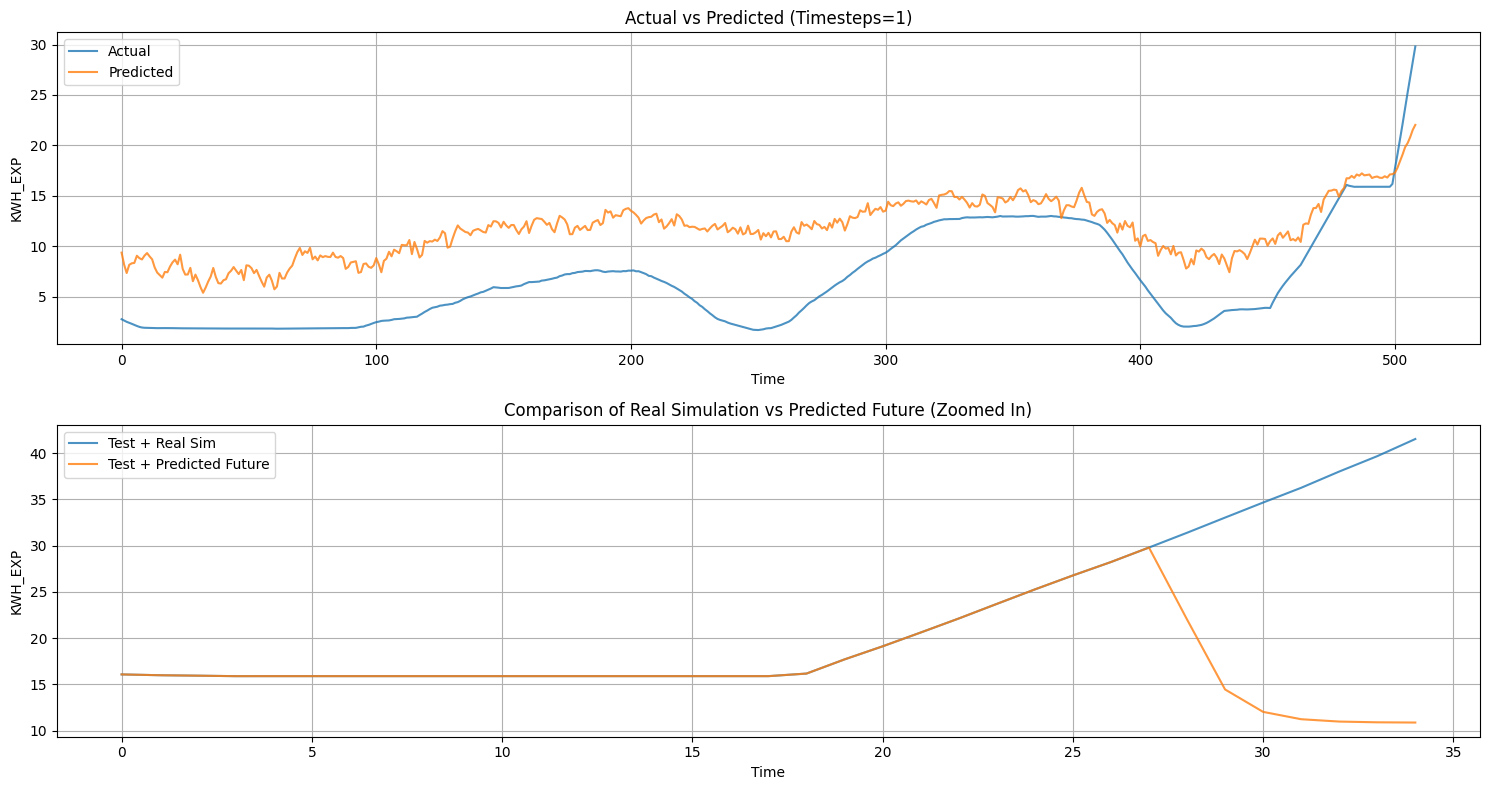


Metrics for timesteps=1:
MSE: 31.1319
R²: -0.3060
MAPE: 1.5613
MAE: 5.0861
Training time for timesteps = 1: 8.20 seconds

Training model with selected features and timesteps = 2
Epoch 46: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_2_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


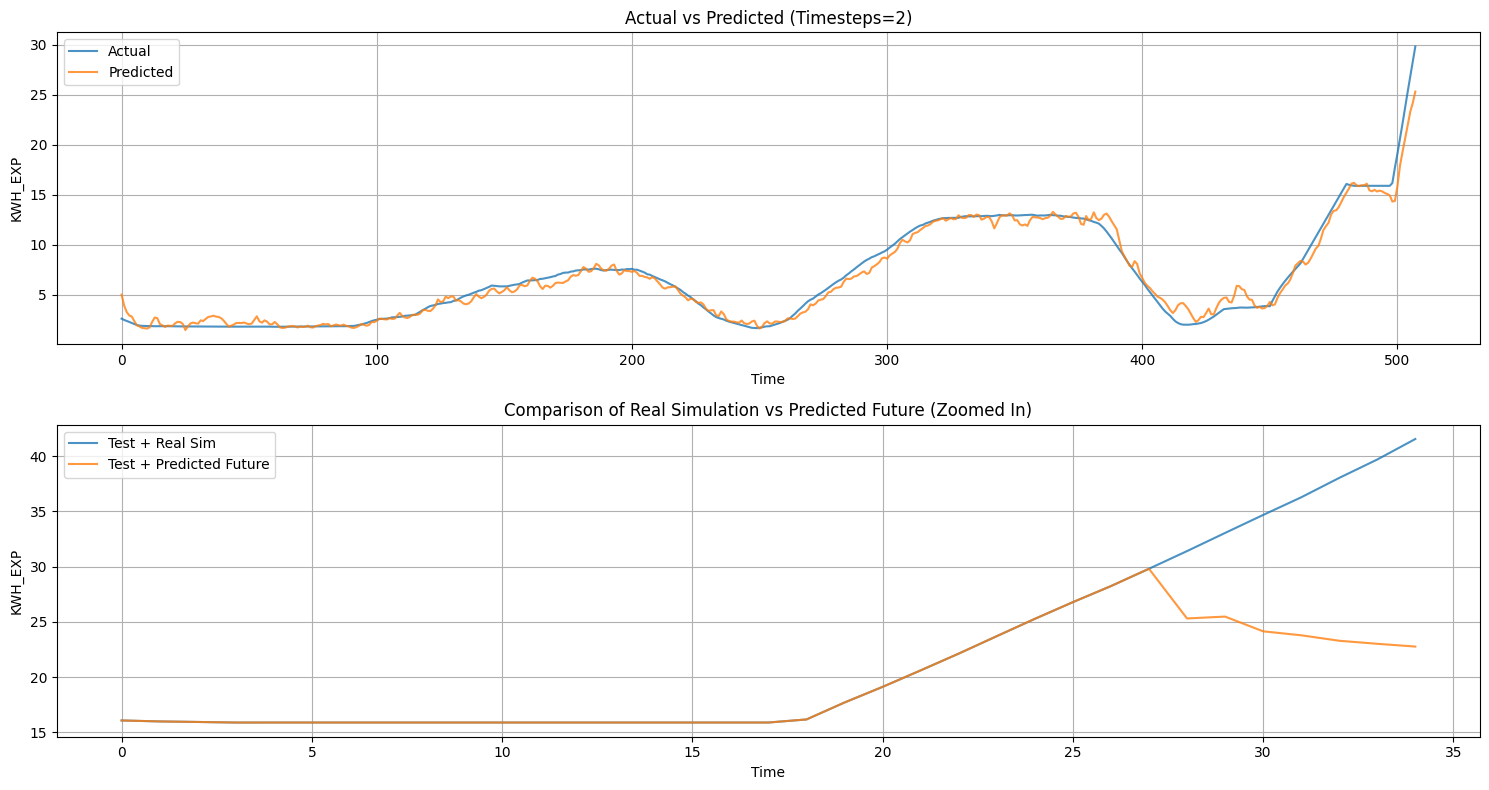


Metrics for timesteps=2:
MSE: 0.5929
R²: 0.9751
MAPE: 0.1112
MAE: 0.5166
Training time for timesteps = 2: 12.06 seconds

Training model with selected features and timesteps = 3
Epoch 16: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


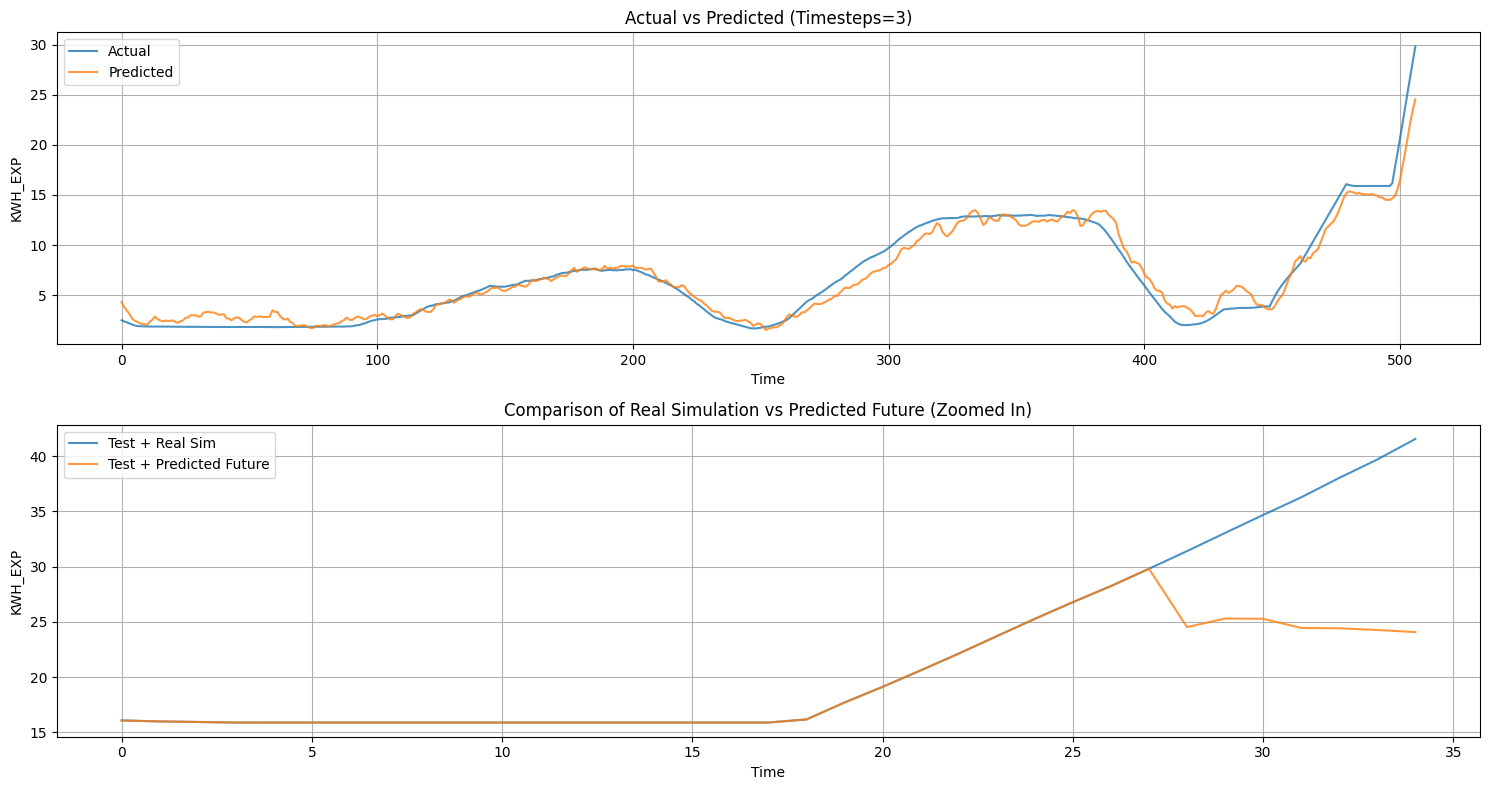


Metrics for timesteps=3:
MSE: 1.1379
R²: 0.9523
MAPE: 0.1789
MAE: 0.7868
Training time for timesteps = 3: 8.11 seconds

Training model with selected features and timesteps = 4
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


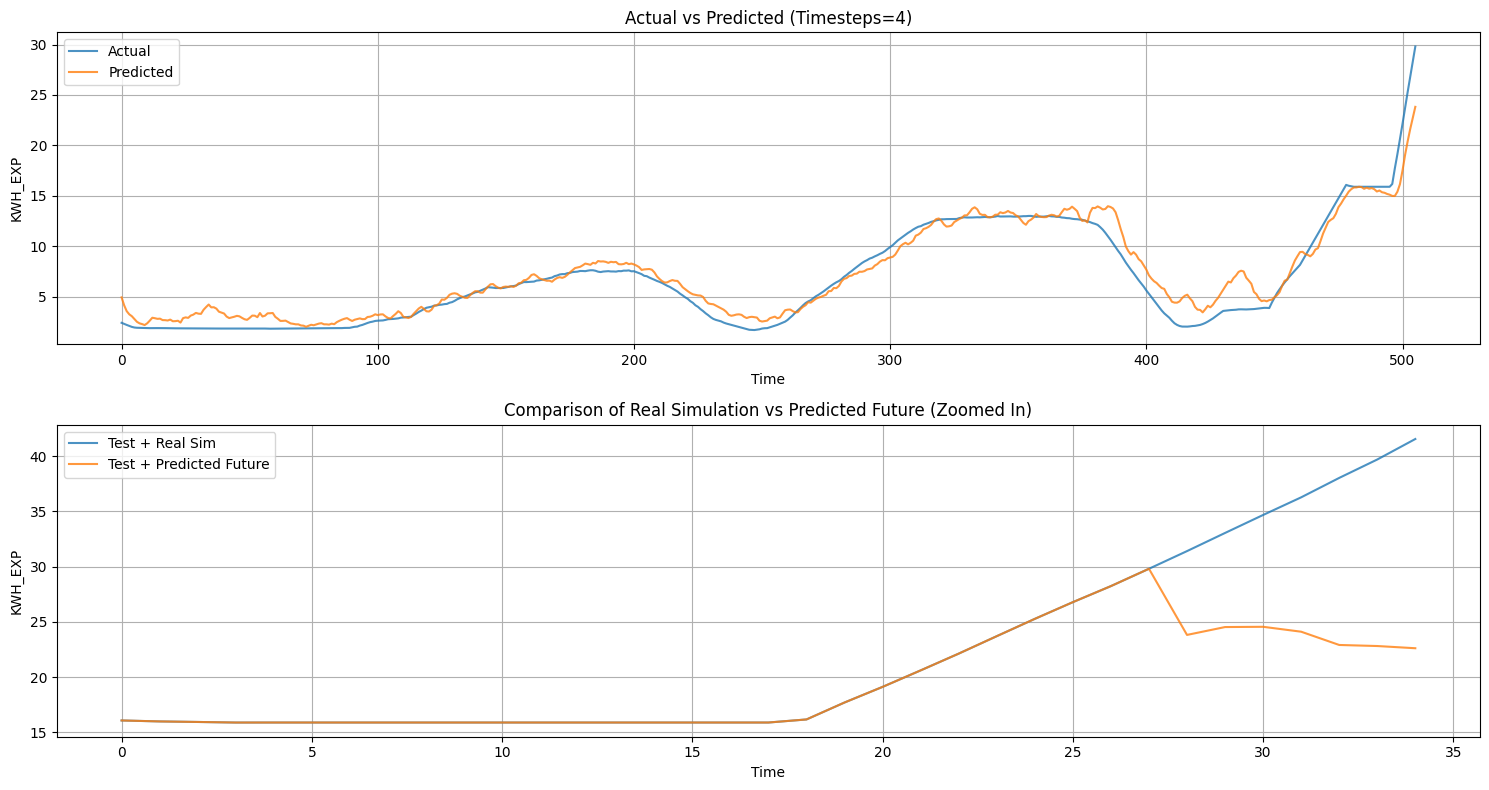


Metrics for timesteps=4:
MSE: 1.6384
R²: 0.9314
MAPE: 0.2507
MAE: 0.9198
Training time for timesteps = 4: 10.81 seconds

Training model with selected features and timesteps = 5
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


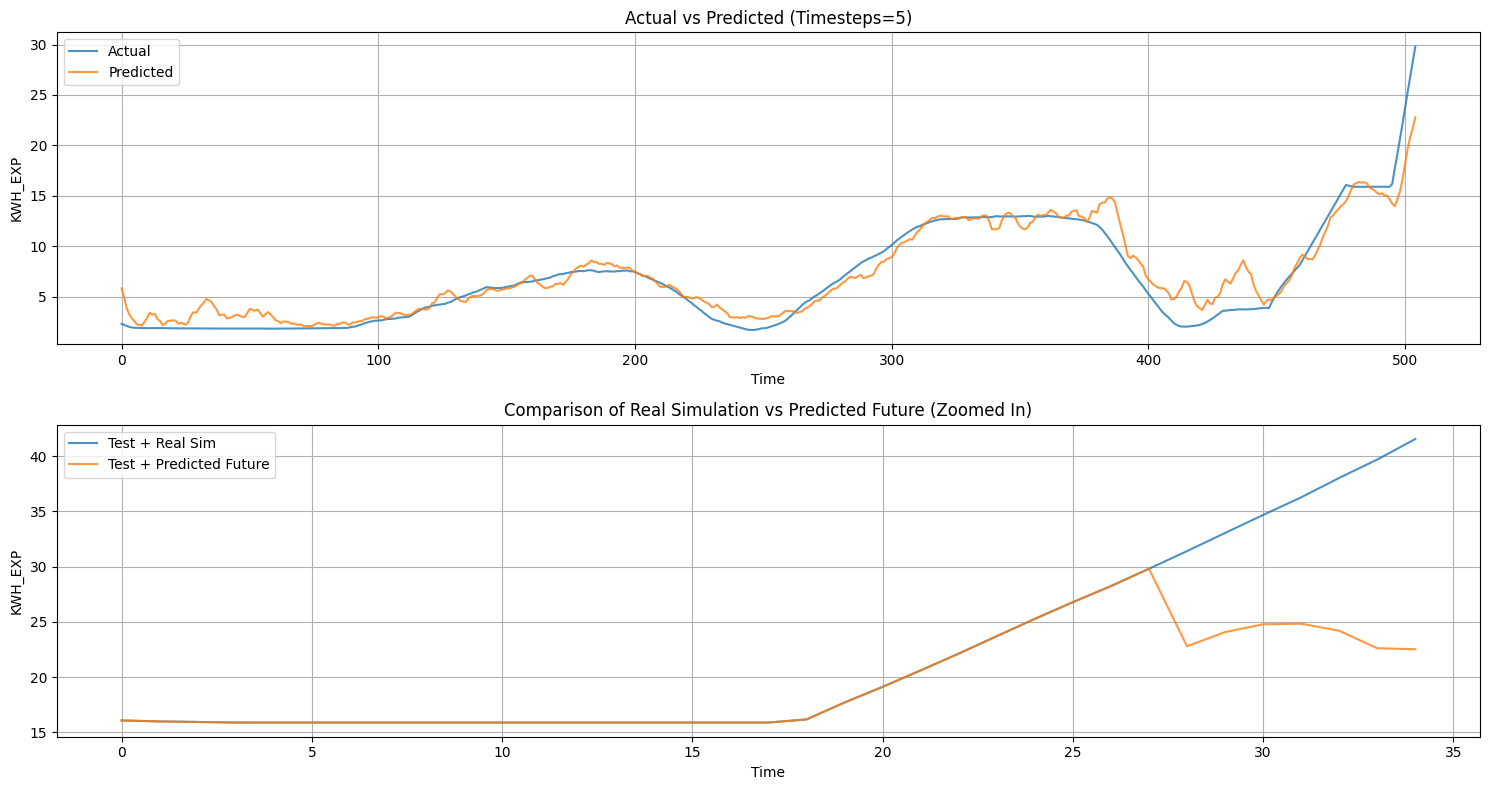


Metrics for timesteps=5:
MSE: 2.1890
R²: 0.9084
MAPE: 0.2710
MAE: 1.0068
Training time for timesteps = 5: 11.23 seconds

Training model with selected features and timesteps = 6
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


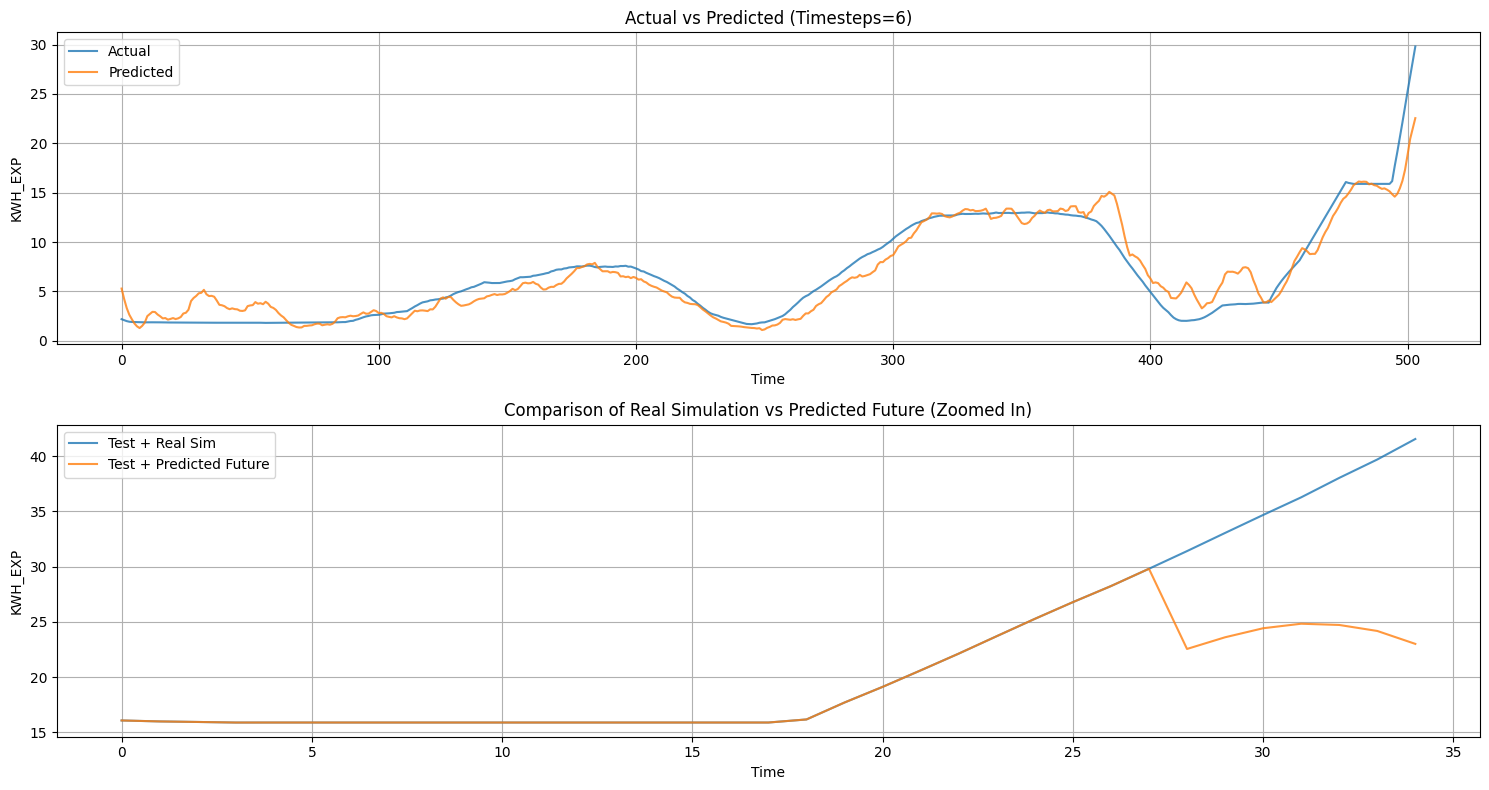


Metrics for timesteps=6:
MSE: 2.4576
R²: 0.8972
MAPE: 0.2797
MAE: 1.1379
Training time for timesteps = 6: 8.89 seconds

Training model with selected features and timesteps = 7
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


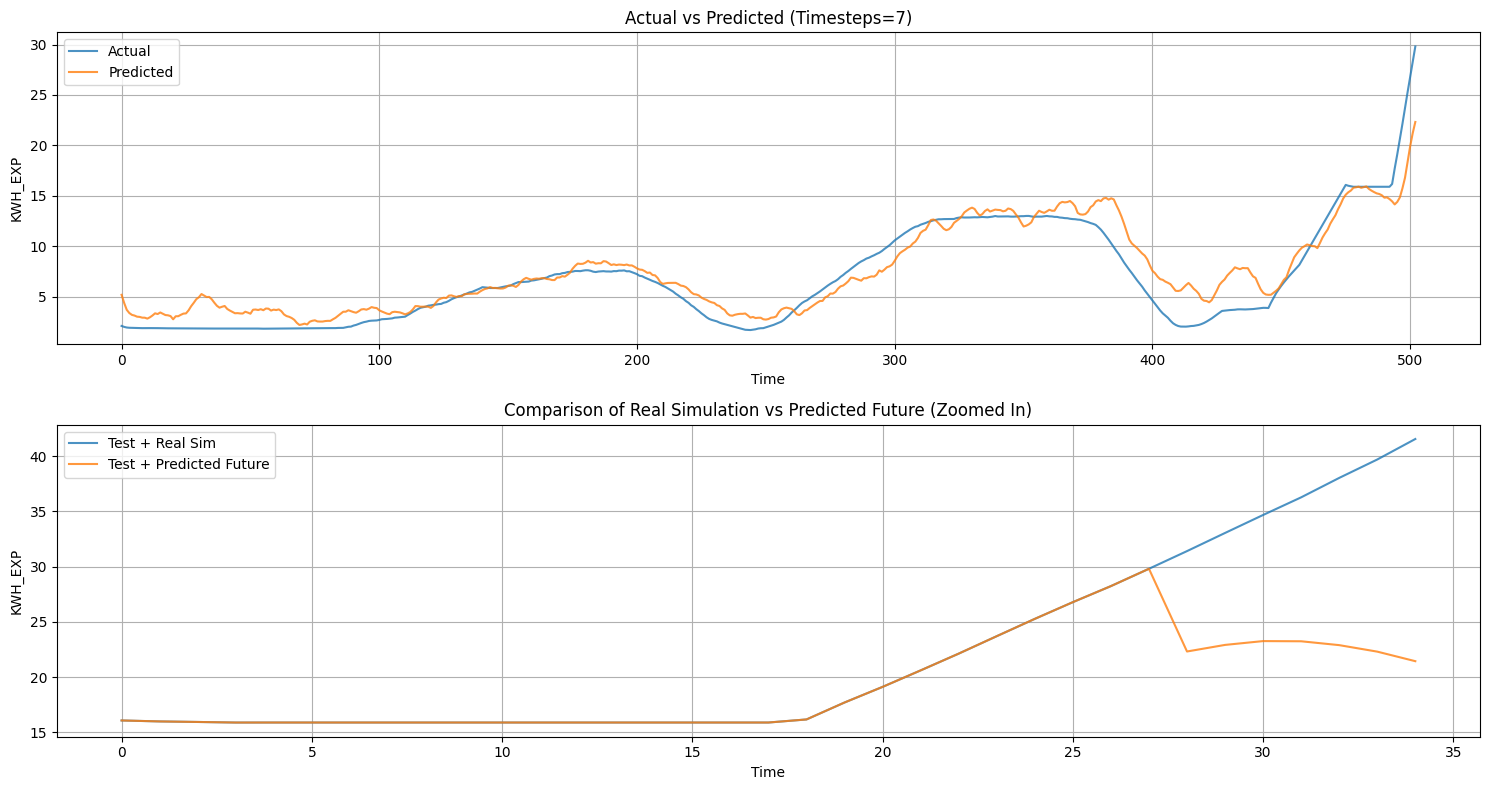


Metrics for timesteps=7:
MSE: 3.3502
R²: 0.8599
MAPE: 0.3732
MAE: 1.3579
Training time for timesteps = 7: 7.78 seconds
Total training execution time: 67.08 seconds


In [58]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [59]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [60]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
Epoch 6: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


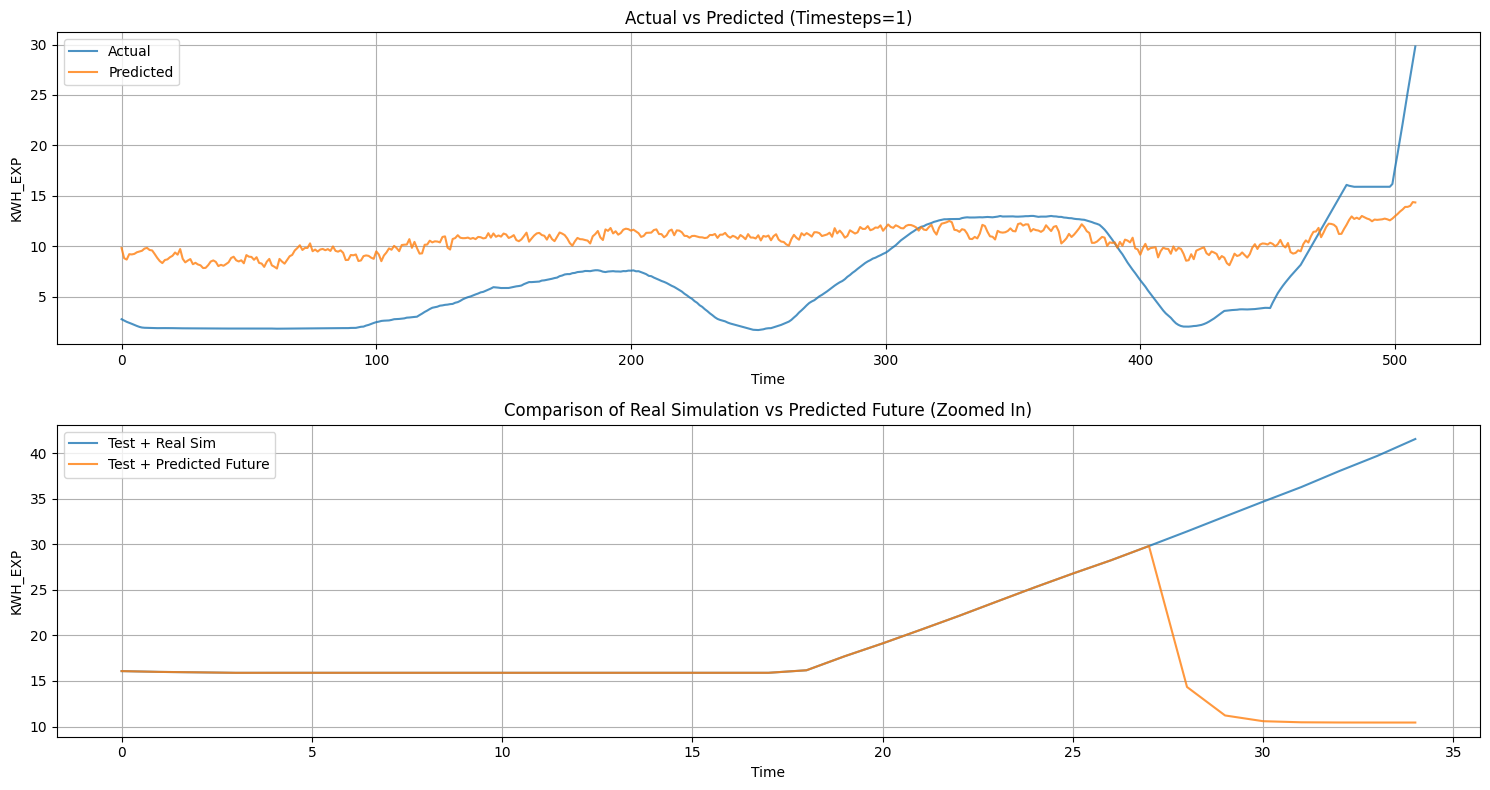


Metrics for timesteps=1:
MSE: 30.8957
R²: -0.2961
MAPE: 1.6011
MAE: 4.9193
Training time for timesteps = 1: 4.61 seconds

Training model with selected features and timesteps = 3
Epoch 20: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


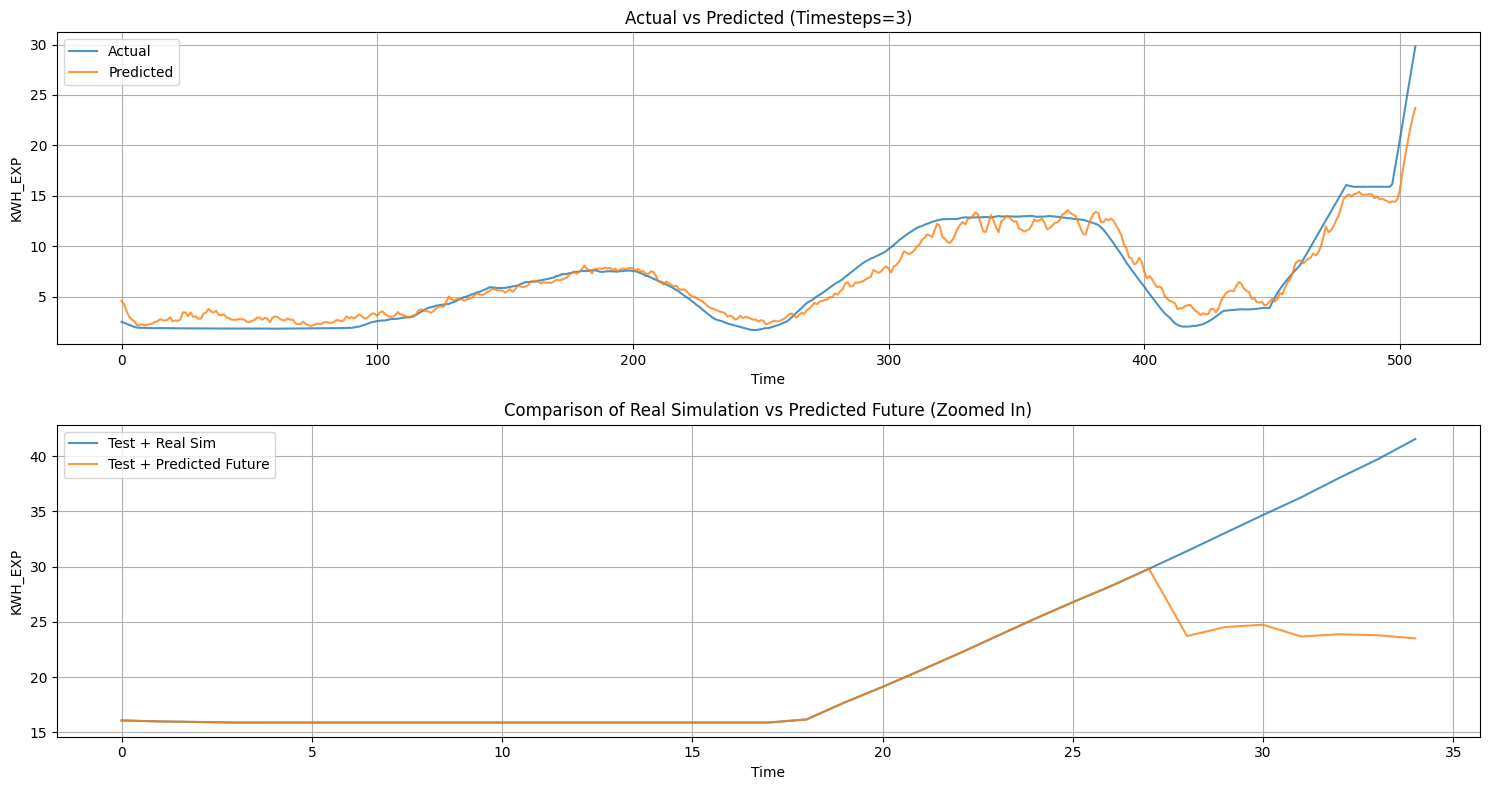


Metrics for timesteps=3:
MSE: 1.4940
R²: 0.9374
MAPE: 0.2218
MAE: 0.9252
Training time for timesteps = 3: 5.86 seconds

Training model with selected features and timesteps = 3
Epoch 28: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


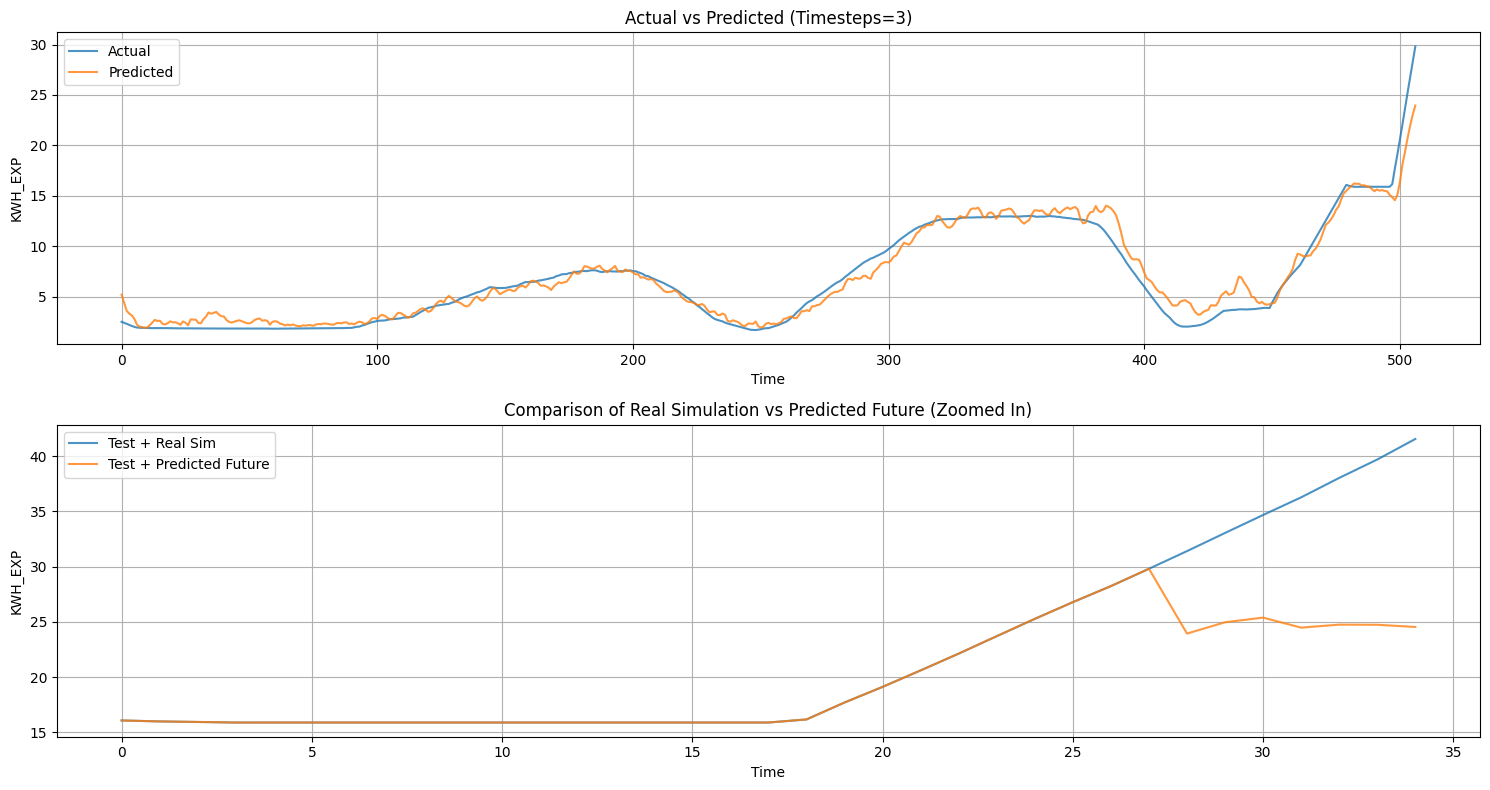


Metrics for timesteps=3:
MSE: 1.1802
R²: 0.9506
MAPE: 0.1805
MAE: 0.7601
Training time for timesteps = 3: 8.16 seconds

Training model with selected features and timesteps = 4
Epoch 40: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


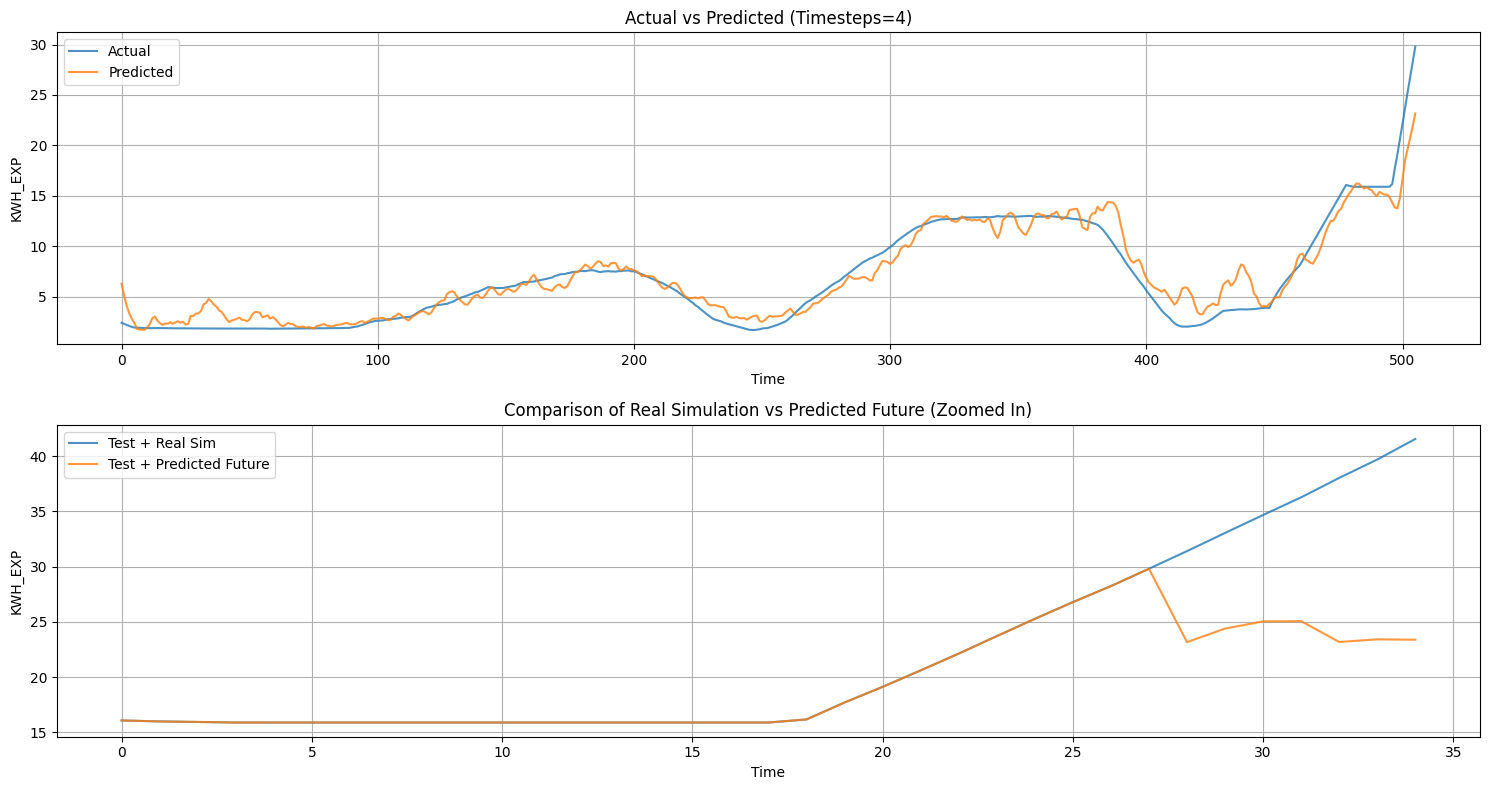


Metrics for timesteps=4:
MSE: 2.0279
R²: 0.9151
MAPE: 0.2439
MAE: 0.9764
Training time for timesteps = 4: 8.90 seconds

Training model with selected features and timesteps = 5
Epoch 32: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


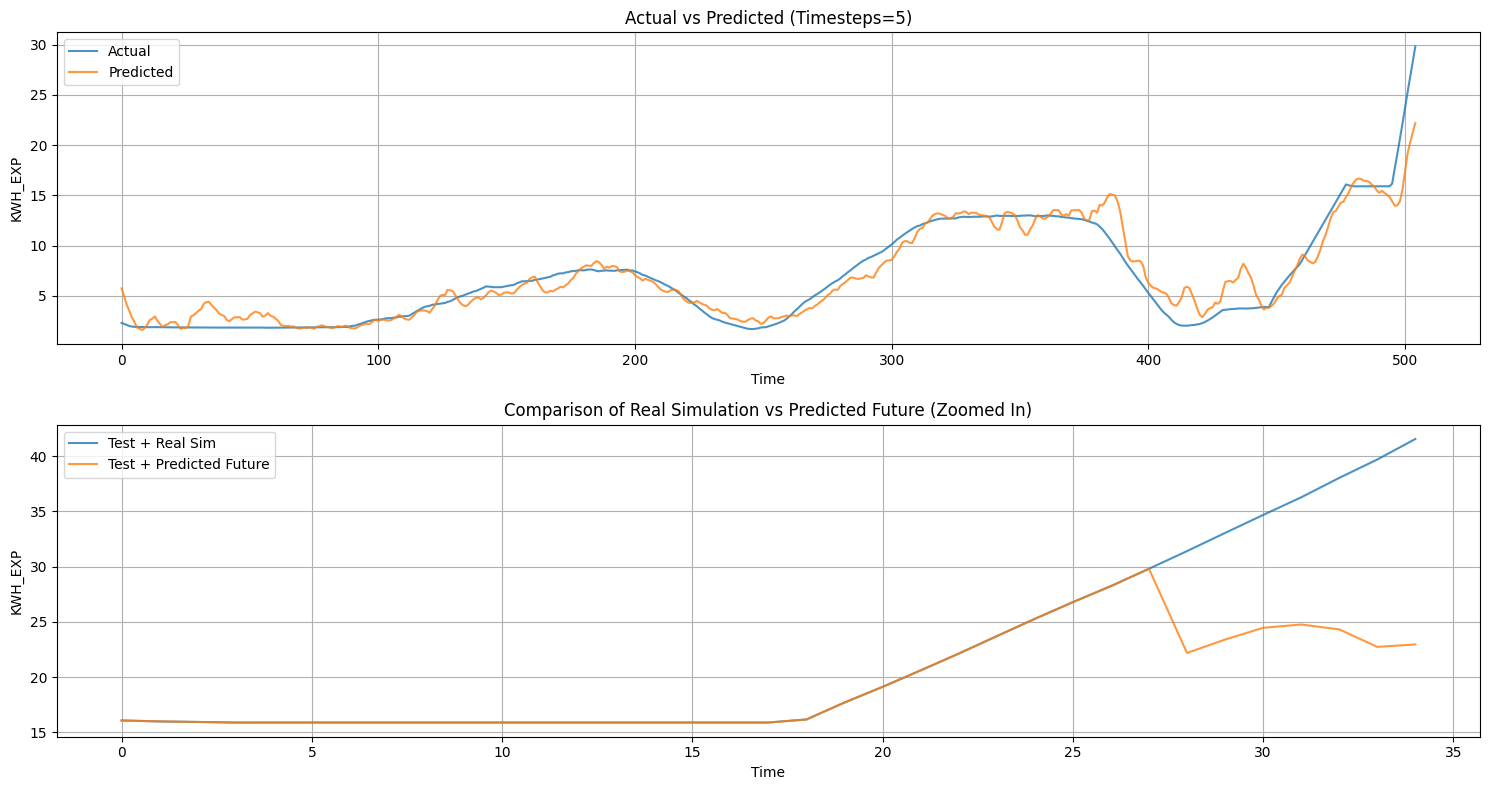


Metrics for timesteps=5:
MSE: 2.1757
R²: 0.9089
MAPE: 0.2253
MAE: 0.9747
Training time for timesteps = 5: 7.62 seconds

Training model with selected features and timesteps = 6
Epoch 14: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


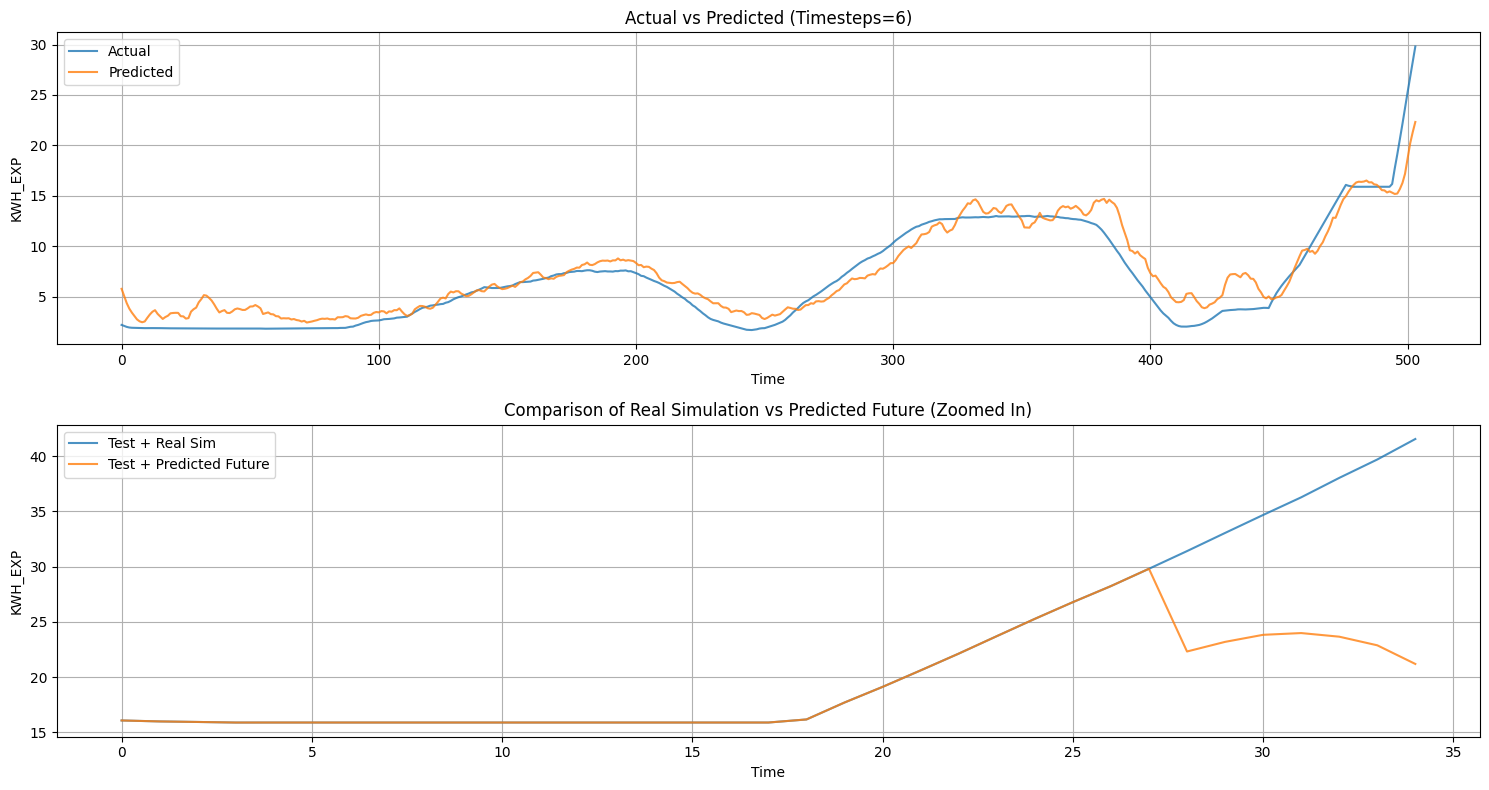


Metrics for timesteps=6:
MSE: 2.7638
R²: 0.8844
MAPE: 0.3445
MAE: 1.2784
Training time for timesteps = 6: 7.91 seconds

Training model with selected features and timesteps = 7
Epoch 15: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


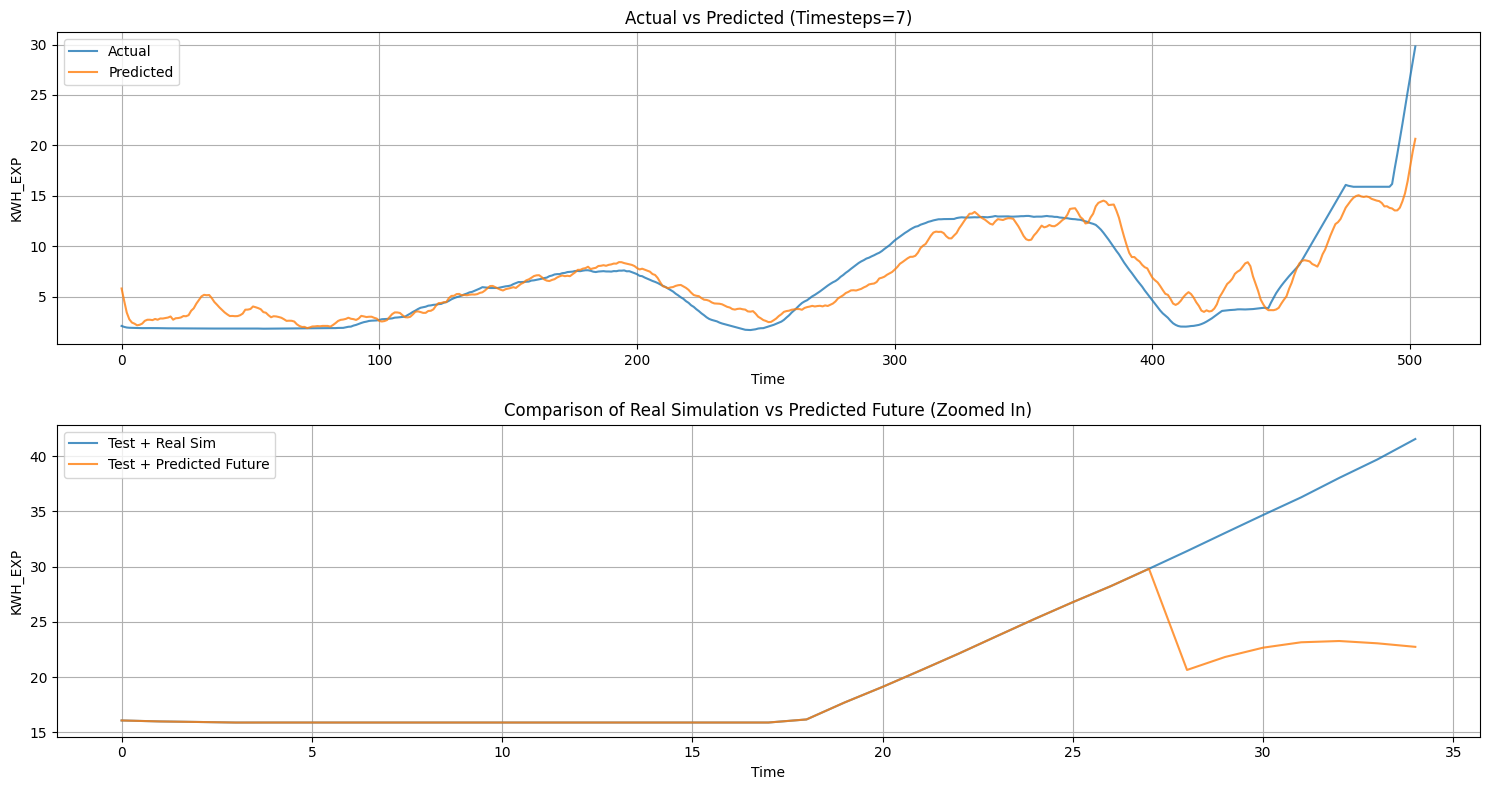


Metrics for timesteps=7:
MSE: 3.6312
R²: 0.8481
MAPE: 0.3236
MAE: 1.3762
Training time for timesteps = 7: 5.57 seconds
Total training execution time: 48.65 seconds


In [61]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")